# Chapter 8:  Boosting, Bagging, Random Forests, Bayesian Additive trees

An ensemble method is an approach that combines many simple “building block” models in order to obtain a single and potentially very powerful model. These simple building block models are sometimes known as weak learners, since they may lead to mediocre predictions on their own.
We will now discuss bagging, random forests, boosting, and Bayesian additive regression trees. These are ensemble methods for which the simple building block is a regression or a classification tree. By aggregating many decision trees, using methods like bagging, random forests, and boosting, the predictive performance of trees can be substantially improved.

# Dataset: Boston

In [2]:
library(ISLR2)
attach(Boston)

head(Boston)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7


In [3]:
#train-test-split
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston)/2)
test = Boston[-train,]
boston.test <- Boston[-train, "medv"]


# Bagging & Random Forest

## Bagging

The decision trees discussed in Section 8.1 suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method.

A natural way to reduce the variance and increase the test set accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. This is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate $B$ different bootstrapped training data sets. We then train our method on the $b$th bootstrapped training set in order to get the $b$th prediction, and finally average all the predictions. This is called bagging.

While bagging can improve predictions for many regression methods,
it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct $B$ regression trees using $B$ bootstrapped training sets, and average the resulting predictions. These trees are grown deep, and are not pruned. Hence each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance. Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.



In [12]:
#install.packages('randomForest')
library(randomForest)

In [4]:
bag.boston <- randomForest(medv ~ ., data = Boston, 
                           subset = train, mtry = 12, importance = TRUE)
yhat <- predict(bag.boston, test)

Recall that bagging is simply a special case of a random forest with $m = p$. Therefore, the *randomForest()* function can be used to perform both random forests and bagging. The argument *mtry = 12* indicates that all 12 predictors should be considered for each split of the tree — in other words, that bagging should be done

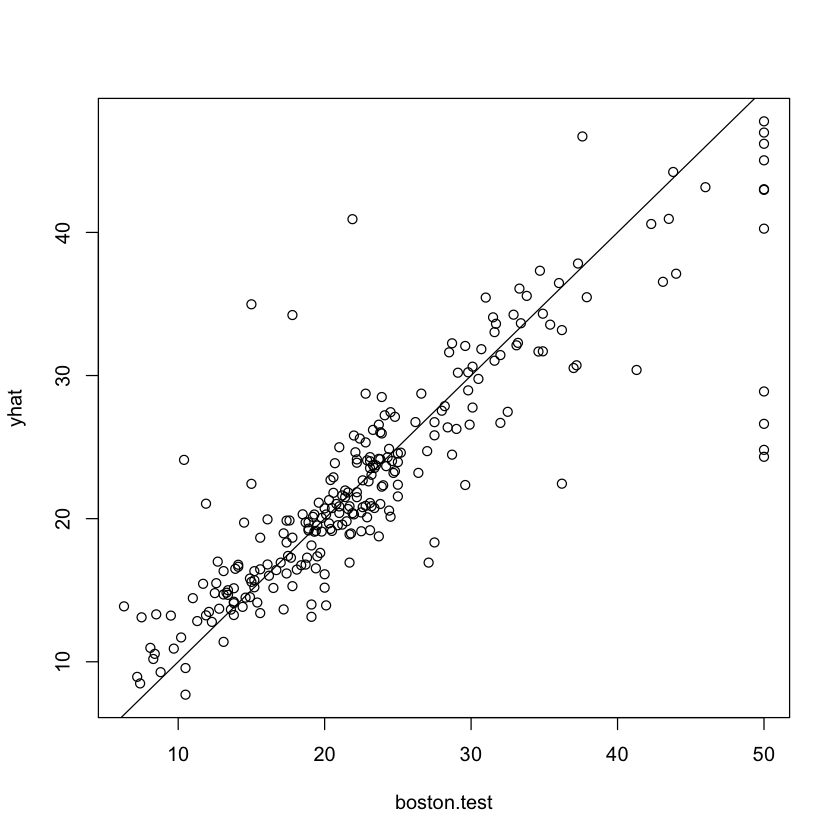

In [5]:
#compare the true and predicted value
plot(boston.test, yhat)
abline(0,1)

In [6]:
#MSE
mean((yhat - boston.test)^2)

[1] 23.40359

## Random Forest

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. 

As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. **The split is allowed to use only one of those $m$ predictors.  A fresh sample of m predictors is taken at each split, and typically we choose $m \approx \sqrt{p}$ — that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors**. The rationale for this is as follows: averaging many highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities. In particular, this means that bagging will not lead to a substantial reduction in variance over a single tree in this setting. Random forests overcome this problem by forcing each split to consider only a subset of the predictors. Therefore, on average $(p − m)/p$ of the splits will not even consider the strong predictor, and so other predictors will have more of a chance. We can think of this process as decorrelating the trees, thereby making the average of the resulting trees less variable and hence more reliable.

Using a small value of $m$ in building a random forest will typically be helpful when we have a large number of correlated predictors. The main difference between bagging and random forests is the choice of predictor subset size $m$. For instance, if a random forest is built using $m = p$, then this amounts simply to bagging. 

In [7]:
#for random forest, choose mtry < p=12
rf.boston <- randomForest(medv ~ ., data = Boston, 
                           subset = train, mtry = 6, importance = TRUE)
yhat.rf <- predict(rf.boston, test)

In [8]:
#MSE
mean((yhat.rf - boston.test)^2)

[1] 19.5178

The MSE of random forest method is smaller than that of bagging method above, which means this method yielded an improvement. Using the *importance()* function, we can view the importance of each variable

In [10]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,15.4241320,1137.83607
zn,3.6465923,100.11749
indus,5.7768966,570.48176
chas,-0.4358076,29.83094
nox,12.0786127,705.40195
rm,34.1438887,8069.21252
age,14.0265168,629.61352
dis,8.0595748,669.82707
rad,3.6622932,103.04074
tax,8.7167625,307.47855


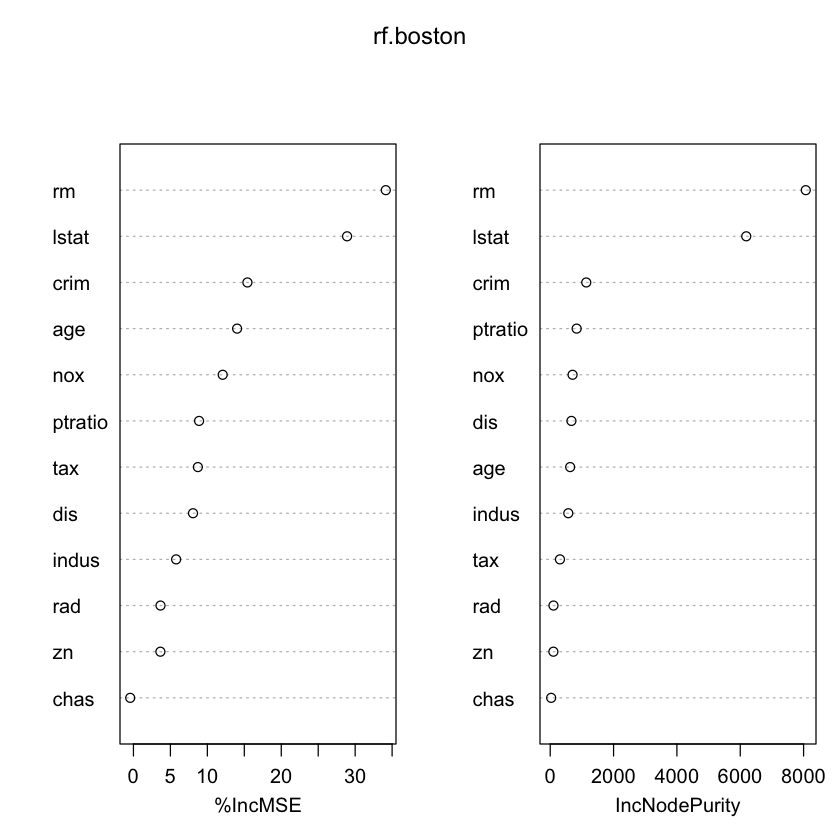

In [11]:
varImpPlot(rf.boston)

# Boosting

We now discuss boosting, yet another approach for improving the predictions resulting from a decision tree. Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification.  Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model. Notably, each tree is built on a bootstrap data set, independent of the other trees. *Boosting works in a similar way, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.*

Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome Y , as the response. We then add this new decision tree into the fitted function in order to update the residuals.
Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

Here we use the *gbm* package, and within it the *gbm()* function, to fit boosted regression trees to the Boston data set. We run *gbm()* with the option distribution = "gaussian" since this is a regression problem; if it were a binary classification problem, we would use distribution = "bernoulli"

In [16]:
library(gbm)

In [18]:
set.seed(1)
boost.boston <- gbm(medv ~., data = Boston[train,], 
                    distribution = 'gaussian', n.trees = 5000,
                   interaction.depth = 4)

The *summary()* function produces a relative influence plot and also outputs the relative influence statistics.

,var,rel.inf
,<chr>,<dbl>
rm,rm,44.48249588
lstat,lstat,32.70281223
crim,crim,4.85109954
dis,dis,4.48693083
nox,nox,3.75222394
age,age,3.19769210
ptratio,ptratio,2.81354826
tax,tax,1.54417603
indus,indus,1.03384666


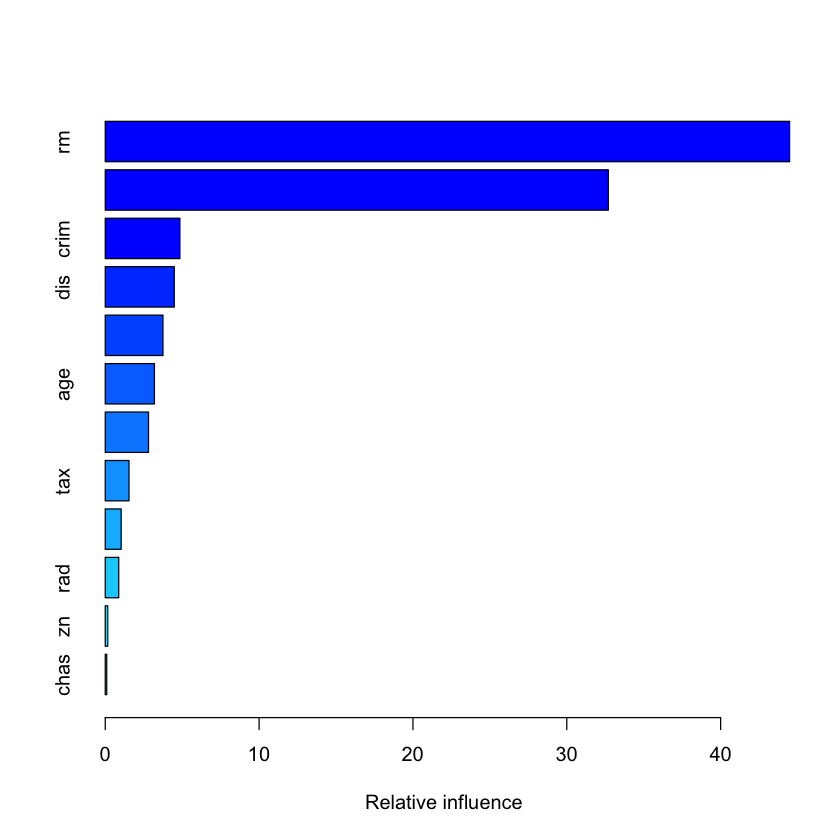

In [19]:
summary(boost.boston)

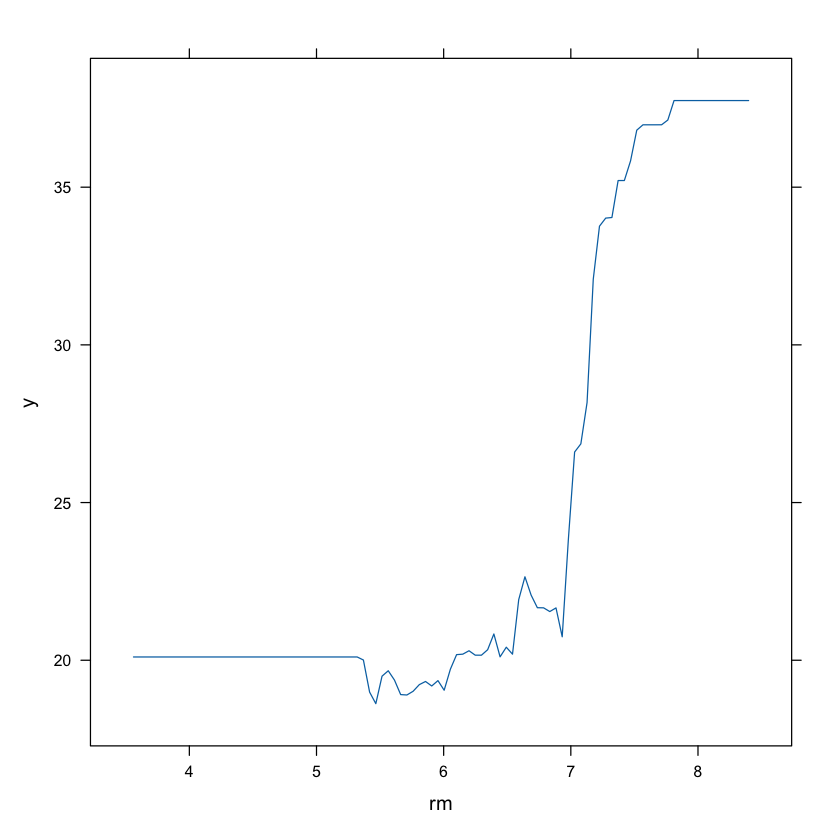

In [20]:
plot(boost.boston, i = "rm")

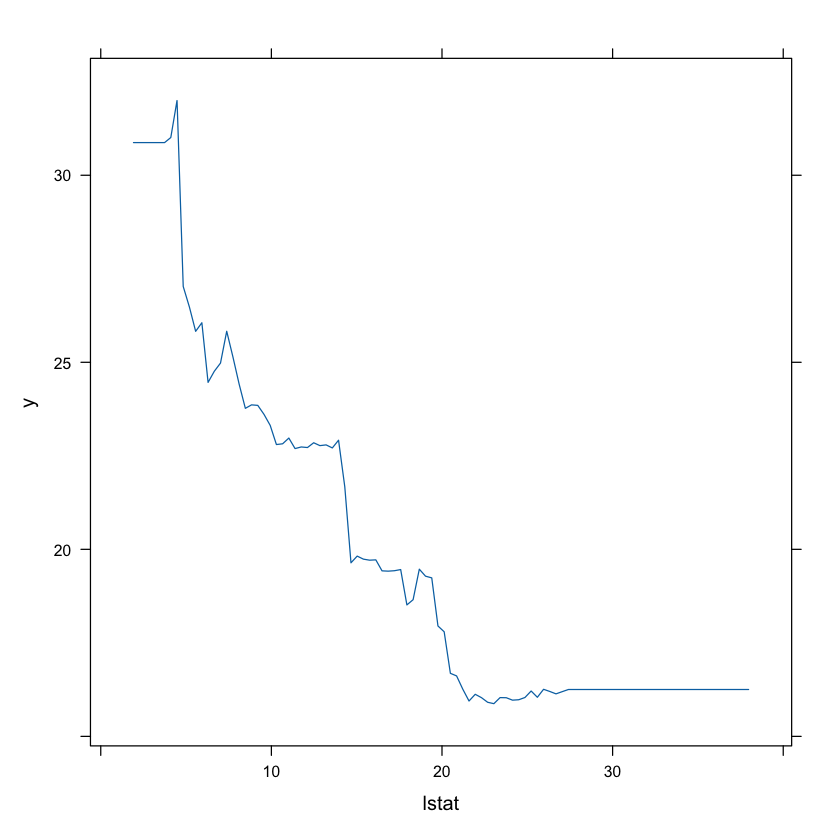

In [21]:
plot(boost.boston, i = "lstat")

In [22]:
yhat.boost <- predict(boost.boston, newdata = test, n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 18.39057

The test MSE obtained is 18.39: this is superior to the test MSE of random forests and bagging.  If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$. The default value is 0.001, but this is easily modified. Here we take $\lambda = 0.2$, which will yield a slight improvement of the MSE.

In [29]:
boost.boston <- gbm(medv ~ ., data = Boston[train, ], distribution = "gaussian", 
                    n.trees = 5000, interaction.depth = 4, 
                    shrinkage = 0.2, verbose = F)
yhat.boost <- predict(boost.boston, newdata = test, n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 17.04683

# Bayesian Additive Regression Trees (BART)

Recall that bagging and random forests make predictions from an average of regression trees, each of which is built using a random sample of data and/or predictors. Each tree is built separately from the others. By contrast, boosting uses a weighted sum of trees, each of which is constructed by fitting a tree to the residual of the current fit. Thus, each new tree attempts to capture signal that is not yet accounted for by the current set of trees. BART is related to both approaches: each tree is constructed in a random manner as in bagging and random forests, and each tree tries to capture signal not yet accounted for by the current model, as in boosting. The main novelty in BART is the way in which new trees are generated.

We use the BART package, and within it the *gbart()* function, to fit a Bayesian additive regression tree model to the Boston housing data set. The *gbart()* function is designed for quantitative outcome variables. For binary outcomes, *lbart()* and *pbart()* are available.
To run the *gbart()* function, we must first create matrices of predictors for the training and test data. We run BART with default settings.

In [24]:
library(BART)

Loading required package: nlme

Loading required package: nnet

Loading required package: survival



In [25]:
x <- Boston[, 1:12]
y <- Boston[, "medv"]
xtrain <- x[train, ]
ytrain <- y[train]
xtest <- x[-train, ]
ytest <- y[-train]

In [26]:
set.seed(1)
bartfit <- gbart(xtrain, ytrain, x.test = xtest)

*****Calling gbart: type=1
*****Data:
data:n,p,np: 253, 12, 253
y1,yn: 0.213439, -5.486561
x1,x[n*p]: 0.109590, 20.080000
xp1,xp[np*p]: 0.027310, 7.880000
*****Number of Trees: 200
*****Number of Cut Points: 100 ... 100
*****burn,nd,thin: 100,1000,1
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.795495,3,3.71636,21.7866
*****sigma: 4.367914
*****w (weights): 1.000000 ... 1.000000
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,12,0
*****printevery: 100

MCMC
done 0 (out of 1100)
done 100 (out of 1100)
done 200 (out of 1100)
done 300 (out of 1100)
done 400 (out of 1100)
done 500 (out of 1100)
done 600 (out of 1100)
done 700 (out of 1100)
done 800 (out of 1100)
done 900 (out of 1100)
done 1000 (out of 1100)
time: 5s
trcnt,tecnt: 1000,1000


In [27]:
yhat.bart <- bartfit$yhat.test.mean 
mean((ytest - yhat.bart)^2)

[1] 15.94718

On this data set, the test error of BART is lower than the test error of random forests and boosting

# References

Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani, **An Introduction to Statistical Learning with Applications in R**, Chapter 8.